## GEO 1001 - Assignment 02
Classification of a Sentinel-2 image

###### Ondrej Veselý, 5162130
###### Carolin Bachert, 5382998


### Introduction
The aim of this assignment is implement in Python a program that classifies a Sentinel-2 image. This is the satellite image for the area around Delft on 2020-05-30, with 3 resolutions.

In [15]:
# import required modules
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import rasterio
from sklearn.cluster import KMeans, MiniBatchKMeans

In [2]:
# import the data
path = './GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/'

import os
from collections import OrderedDict

def load_jp2(path):
  d = OrderedDict()
  for file in os.listdir(path):
    if file.endswith('.jp2'):
      id = file.split('_')[2]
      full_path = path + file
      d[id] = ds = rasterio.open(full_path)
      
  return d      

r60m = load_jp2(path + 'R60m/')
r20m = load_jp2(path + 'R20m/')
r10m = load_jp2(path + 'R10m/')

## First visual check

With the data and required modules imported, as first step we plot all the bands of the r60m dataset to test if everything is working properly and have first visual representation of our data.

In the picture below, 15 different bands are plotted in the resolution of 60m.  

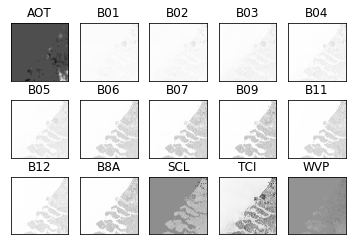

In [7]:
for i, (band, data) in enumerate(r60m.items()):
  ax = plt.subplot2grid((3,5), (i//5, i%5))
  ax.imshow(data.read()[0], cmap='binary')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title(band)

plt.show()

## RGB plot
In order to have a more 'human-readable' representation of the dataset and a reference for evaluation of the classified images we create a pseudo-true colour raster image by combining the red, green and blue band.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


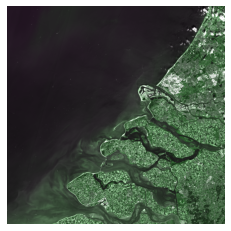

In [11]:
# pseudo rgb
bands = ['B02', 'B03', 'B02']
dataset = r60m

data = [dataset[band] for band in bands if band in dataset]
stack = np.array([img.read()[0].flatten()/2000 for img in data]).T
rgb_arr = np.array(np.split(stack, data[0].width))

plt.axis('off')
plt.imshow(rgb_arr)

## First try at k-means
For start, lets try setting up simple k-means classifier with red and blue bands as input and see how far it can get us.

Label 0: 2596958 occurences
Label 1: 671554 occurences
Label 2: 80388 occurences


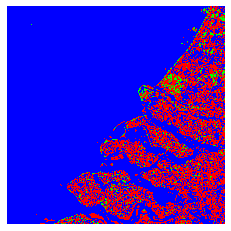

In [12]:
# parameters
bands = ['B02', 'B04']
dataset = r60m
n_labels = 3
seed = 1


data = [dataset[band] for band in bands if band in dataset]
stack = np.array([img.read()[0].flatten() for img in data]).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, data[0].width))

for i in range(n_labels):
  print('Label %s: %s occurences' % (i, np.count_nonzero(kmeans.labels_ == i)))

plt.axis('off')
plt.imshow(label_arr, cmap='brg', interpolation='nearest')

With only two variables as an input, we start slow with setting number of k-means cluster to 3. From comparison of previous RGB raster and the resulting classification, we can deduce the following;
- Label 0 *(Blue in 'brg' cmap)*: **2596958 occurences**, probably water and other low-albedo surfaces
- Label 1 *(Red in 'brg' cmap)*: **671554 occurences**, generic landcover
- Label 2 *(Green in 'brg' cmap)*: **80388 occurences**, e.g. greenhouses and other high-albedo surfaces

Let's take a better look at how the classes look in a scatter plot.

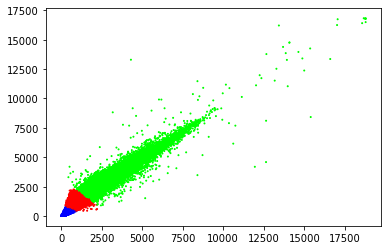

In [13]:
plt.scatter(stack.T[0], stack.T[1], s=1, c=kmeans.labels_, cmap='brg')

From the scatterplot, we can fairly easily observe several things;

- Bands **B02** and **B04** are highly correlated, judging from the linear appearance of the plot.
- Most of the values are ranging in between **0 to 10000** on the 16-bit uint range.
- Knowing that the most occurent Label is Label 0 (displayed as **blue** here and the second most after that Label 1 (**red**), we know that the lower left corner of the scatterplot is much more densily populated then is obivous from the image.

Let's zoom in onto the lower left corner of the plot to see if we can observe some clustering that k-means hasn't registered in there.

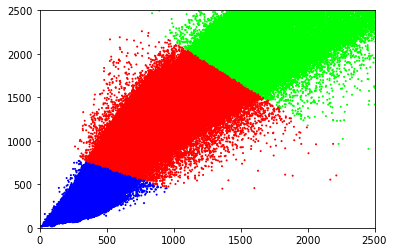

In [15]:
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.scatter(stack.T[0], stack.T[1], s=1, c=kmeans.labels_, cmap='brg')


But the zoom only confirms what we thought before. The high correlation of the bands results in k-means classifying the datapoints based almost only their total reflectivity.

In order to improve the result, we have to more carafully choose the bands on which the classification is based. 
Bands which have a high correlation coefficient, show a high level of data redundancy. Hence, comparing such bands *(as in example above)*, doesn't usually lead to very meaningful results.

Let's first plot a corellation matrix (here Pearson correlation is used) for all bands of the r60m dataset,
and try to use to identify the most applicable bands for classification.

In [16]:
data = r60m

matrix = []
for a in data.values():
  row = []
  for b in data.values():
    row.append(
      round(ndigits=2,
            number=stats.pearsonr(a.read()[0].flatten(), 
                                  b.read()[0].flatten())[0]))matrix.append(row)

pd.DataFrame(matrix, columns=data.keys(), index=data.keys())

,AOT,B01,B02,B03,B04,B05,B06,B07,B09,B11,B12,B8A,SCL,TCI,WVP
AOT,1.00,0.05,0.06,0.05,0.04,0.01,-0.03,-0.04,-0.04,-0.05,-0.02,-0.05,0.10,0.04,0.12
B01,0.05,1.00,0.95,0.88,0.85,0.75,0.47,0.40,0.42,0.57,0.64,0.38,0.05,0.76,-0.12
B02,0.06,0.95,1.00,0.96,0.93,0.82,0.53,0.46,0.47,0.65,0.72,0.44,-0.02,0.85,-0.15
B03,0.05,0.88,0.96,1.00,0.98,0.93,0.71,0.65,0.65,0.80,0.84,0.63,-0.24,0.93,-0.13
B04,0.04,0.85,0.93,0.98,1.00,0.95,0.71,0.64,0.64,0.85,0.90,0.63,-0.27,0.97,-0.19
B05,0.01,0.75,0.82,0.93,0.95,1.00,0.88,0.83,0.83,0.95,0.94,0.82,-0.49,0.94,-0.11
B06,-0.03,0.47,0.53,0.71,0.71,0.88,1.00,0.99,0.99,0.92,0.82,0.99,-0.72,0.72,0.09
B07,-0.04,0.40,0.46,0.65,0.64,0.83,0.99,1.00,0.99,0.89,0.77,1.00,-0.75,0.66,0.13
B09,-0.04,0.42,0.47,0.65,0.64,0.83,0.99,0.99,1.00,0.89,0.77,0.99,-0.73,0.65,0.11
B11,-0.05,0.57,0.65,0.80,0.85,0.95,0.92,0.89,0.89,1.00,0.97,0.89,-0.64,0.87,-0.14


Lets try bands.

In [18]:
# parameters
bands = ['AOT', 'B01', 'B03', 'B05', 'B09', 'B11', 'SCL', 'TCI', 'WVP']
dataset = r60m
n_labels = 6
seed = 2


data = [dataset[band] for band in bands if band in dataset]
stack = np.array([img.read()[0].flatten() for img in data]).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, data[0].width))

for i in range(n_labels):
  print('Label %s: %s occurences' % (i, np.count_nonzero(kmeans.labels_ == i)))
  

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

Label 0: 2242790 occurences
Label 1: 361934 occurences
Label 2: 225387 occurences
Label 3: 25670 occurences
Label 4: 265270 occurences
Label 5: 227849 occurences


In [17]:
# parameters
bands = r60m.keys()
dataset = r60m
n_labels = 6
seed = 2


data = [dataset[band] for band in bands if band in dataset]
stack = np.array([img.read()[0].flatten() for img in data]).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, data[0].width))

for i in range(n_labels):
  print('Label %s: %s occurences' % (i, np.count_nonzero(kmeans.labels_ == i)))

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

Label 0: 2241468 occurences
Label 1: 338835 occurences
Label 2: 267416 occurences
Label 3: 264004 occurences
Label 4: 216530 occurences
Label 5: 20647 occurences


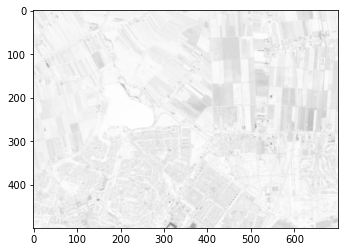

In [67]:
# location of subset
subset = (601200.0, 5773695.0, 700, 500)

def crop(ds, x, y, row, col):
  row_off,col_off = ds.index(x,y)
  window = rasterio.windows.Window(col_off, row_off, row, col)
  return ds.read(window=window)[0]
     
plt.imshow(
  crop(r10m['B04'], *subset), cmap='binary')

Label 0: 8966 occurences
Label 1: 62989 occurences
Label 2: 48843 occurences
Label 3: 69055 occurences
Label 4: 8605 occurences
Label 5: 53742 occurences
Label 6: 97800 occurences


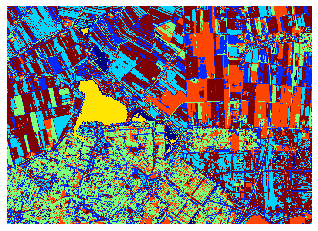

In [65]:
# parameters
bands = r10m.keys()
dataset = r10m
subset = (601200.0, 5773695.0, 700, 500)
n_labels = 7
seed = 1


data = [dataset[band] for band in bands if band in dataset]
stack = np.array([crop(img, *subset).flatten() for img in data]).T
kmeans = MiniBatchKMeans(n_clusters=n_labels, random_state=seed).fit(stack)
label_arr = np.array(np.split(kmeans.labels_, subset[3]))

for i in range(n_labels):
  print('Label %s: %s occurences' % (i, np.count_nonzero(kmeans.labels_ == i)))

plt.axis('off')
plt.imshow(label_arr, cmap='jet', interpolation='nearest')

Maybe in the end, could be nice to crop the 60m resolution to the same extend and compare how this area looks classified in different resolutions ( using the same parameters) --> so takeaway could for example be that the result is not better in a higher resolution so it's not worth the higher "costs" (e.g. in terms of computation time)

Conclusion:
Pros and Cons of our method. 
As a lookout: Maybe think about other classification algorithms that are better fitted to the task. Or think about a ground truth we could take into consideration to improve results (for example the corine or landcover dataset?)